In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.filterwarnings('ignore')

In [2]:

data = pd.read_csv('file.csv')
df_reset=data.reset_index()

In [3]:
# filtering age
df_age=df_reset[(df_reset.Age > 18) &(df_reset.Age < 65)]
# filtering employment status
filter_employmnt_status = ['Employed full-time','Not employed, but looking for work',\
              'Independent contractor, freelancer, or self-employed','Employed part-time']
df_empl=df_age[df_age.EmploymentStatus.isin(filter_employmnt_status)]
# filtering gender, country, and formal education
df_filtered=df_empl.loc[(df_empl['GenderSelect']!='A different identity')&\
                        (df_empl['GenderSelect']!='Non-binary, genderqueer, or gender non-conforming')\
                       & (df_empl['Country']=='United States') & (df_empl['FormalEducation']!='I prefer not to answer')]
# filtering career switchers  who are not data scientists yet
df_career_switch=df_filtered.loc[(df_filtered['CareerSwitcher']=='Yes')&(df_filtered['CurrentJobTitleSelect']!='Data Scientist')]
# changing employment status of career switchers since they are also looking for data science jobs
df_career_switch['EmploymentStatus']=df_career_switch['EmploymentStatus'].replace('Employed full-time','Looking for data science jobs')
df_career_switch['EmploymentStatus']=df_career_switch['EmploymentStatus'].replace('Employed part-time','Looking for data science jobs')
df_career_switch['EmploymentStatus']=df_career_switch['EmploymentStatus'].replace('Independent contractor, freelancer, or self-employed','Looking for data science jobs')
# filtering data scientists who are currently employed
df_employed=df_filtered.loc[(df_filtered['CurrentJobTitleSelect']=='Data Scientist') \
                      & (df_filtered['EmploymentStatus']=='Employed full-time')]
# filtering unemployed who are looking for data science jobs
df_unemployed=df_filtered.loc[df_filtered['EmploymentStatus']=='Not employed, but looking for work']
df_unemployed['CurrentJobTitleSelect']='Unemployed'
df_unemployed['EmploymentStatus']=df_unemployed['EmploymentStatus'].replace('Not employed, but looking for work','Looking for data science jobs')
# combining all data frames
df=pd.concat([df_employed, df_unemployed,df_career_switch])


In [4]:
# creating column 'current job status'
def empl_status(CurrentJobTitleSelect):
    if CurrentJobTitleSelect =='Data Scientist':
        return 'Employed FullTime'
    if CurrentJobTitleSelect =='Unemployed':
        return 'Unemployed'
    else:
        return 'Career Switcher'
    
df['CurrentJobStatus']=df['CurrentJobTitleSelect'].map(empl_status)

In [5]:
# polishing majors
def major(x):
    if x=='Computer Science':
        return x
    elif x=='Mathematics and Statistics':
        return x
    elif x=='Engineering (non-computer focused)':
        return 'Engineering'
    elif x=='Electrical Engineering':
        return 'Engineering'
    elif x=='A social science':
        return 'Social Science'
    elif x=='Psychology':
        return 'Social Science'
    elif x=="Physics":
        return x
    elif x=='Biology':
        return "Health Science and Biology"
    elif x=='A health science':
        return "Health Science and Biology"
    elif x=='A humanities discipline':
        return "Humanities and Art"
    elif x=='Fine arts or performing arts':
        return "Humanities and Art"
    elif x=='Information technology, networking, or system administration':
        return "Information Technology and Managment"
    elif x=='Management information systems':
        return "Information Technology and Managment"
    elif x=='I never declared a major':
        return 'No declared major'
    else:
        return x
df['Major']=df['MajorSelect'].map(major)

In [6]:
# categorizing age into categories
def age_cat(Age):
    if Age<=30:
        return '30 and less'
    if Age >30 and Age <=40:
        return '30 - 40'
    if Age >40  and Age <=50:
        return '40 - 50'
    if Age>50:
        return "over 50"
df['Age_cat']=df['Age'].apply(age_cat)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 41 to 16631
Data columns (total 65 columns):
index                             1498 non-null int64
GenderSelect                      1496 non-null object
Country                           1498 non-null object
Age                               1498 non-null float64
EmploymentStatus                  1498 non-null object
StudentStatus                     0 non-null object
LearningDataScience               0 non-null object
CodeWriter                        1039 non-null object
CareerSwitcher                    374 non-null object
CurrentJobTitleSelect             1478 non-null object
TitleFit                          992 non-null object
CurrentEmployerType               1000 non-null object
LearningDataScienceTime           707 non-null object
DataScienceIdentitySelect         807 non-null object
FormalEducation                   1473 non-null object
MajorSelect                       1340 non-null object
Tenure               

In [8]:
df_working=df[['GenderSelect','Age_cat','FormalEducation','Major',\
        'Tenure','FirstTrainingSelect','EmploymentStatus',\
       'LearningCategoryWork','LearningCategorySelftTaught',\
       'LearningCategoryOnlineCourses','LearningCategoryUniversity',\
       'LearningCategoryKaggle','LearningCategoryOther', 'CurrentJobStatus']].reset_index()

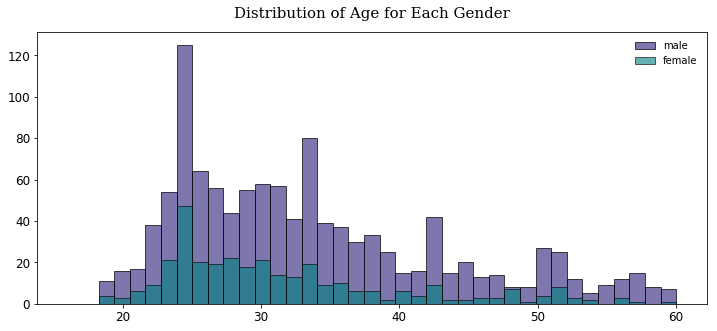

In [10]:
y_ms = df['Age'][df['GenderSelect'] == 'Male']
y_fs = df['Age'][df['GenderSelect'] == 'Female']




bins = np.linspace(16, 60, 40)
plt.figure(figsize=(12,5))
plt.title("Distribution of Age for Each Gender",fontsize=15,y=1.03,family='serif')
plt.hist(y_ms,bins, label='male', alpha=.7, facecolor='darkslateblue',edgecolor = 'k')
plt.hist(y_fs,bins, alpha=.6, label='female', color='teal',edgecolor = 'k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False)
ax = plt.gca()
ax.set_facecolor('white')

plt.show()

In [11]:
print ('Median male age:', y_ms.median())
print ('Median female age:', y_fs.median())
print ('Mean male age:', round(y_ms.mean(),2))
print ('Mean female age:', round(y_fs.mean(),2))

Median male age: 31.0
Median female age: 29.0
Mean male age: 33.96
Mean female age: 31.73


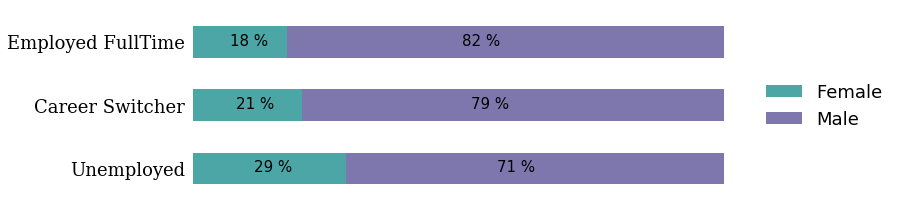

In [12]:
df1 = pd.DataFrame(columns=['Gender','Status','Percentage'])
JobStatus=list(df_working.CurrentJobStatus.unique())
for status in JobStatus:
    y=df_working[df_working['CurrentJobStatus']==status]
    data=pd.DataFrame(y['GenderSelect'].value_counts(normalize=True)).reset_index()
    data['CurrentJobStatus']=status
    for index, row in data.iterrows():
        df1=df1.append({'Gender':row['index'], \
                              'Status':row['CurrentJobStatus'],\
                              'Percentage':row['GenderSelect']},\
                             ignore_index=True)
    
        df2=pd.pivot_table(df1, index=['Gender'], values=['Percentage'], \
                   columns='Status',aggfunc='sum').T.reset_index().iloc[:,1:].\
        sort_values(by='Male',ascending=True)


plt.style.use('ggplot')
ax=df2.plot.barh(stacked=True,color=['teal', 'darkslateblue'], alpha=.7,figsize=(10,3.5))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f} %'.format(width*100), (p.get_x()+.4*width, p.get_y()+.4*height),size=15)
ax.set_facecolor('white')
ax.get_xaxis().set_ticks([])
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_yticklabels(df2['Status'], size =18,family='serif', color='black')
leg=ax.legend(['Female', 'Male'], loc='best', \
          fontsize=10,bbox_to_anchor=(1, .7),prop={'size':18}) 
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')
ax.yaxis.grid(False)
plt.show()

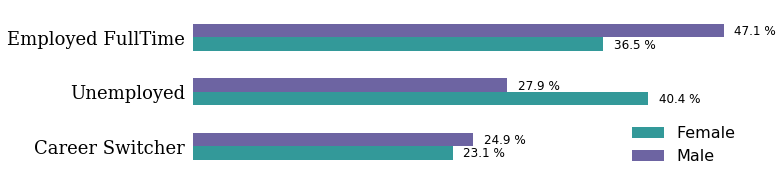

In [13]:
df1=df_working.groupby(['GenderSelect','CurrentJobStatus']).agg({'index': 'count'})
df2= df1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
df3=pd.pivot_table(df2, index=['GenderSelect'], values=['index'], \
                   columns='CurrentJobStatus',aggfunc='mean').T.reset_index().iloc[:,1:].sort_values(by='Male',ascending=True)

ax = df3[['Female','Male']].plot(kind='barh',
              figsize=(10,3), color=['teal','darkslateblue'],\
                                  fontsize=13, alpha=.8)

for i in ax.patches:
        ax.text(i.get_width()+.96, i.get_y()+.05, \
            '{:.1f} %'.format(i.get_width()), fontsize=12)
leg=ax.legend([ 'Female', 'Male'], loc='lower right', \
          fontsize=10,prop={'size':16},bbox_to_anchor=(1, -.03)) 
ax.set_facecolor('white')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.get_xaxis().set_ticks([])
ax.set_yticklabels(df3['CurrentJobStatus'], size =18,family='serif', color='black')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')



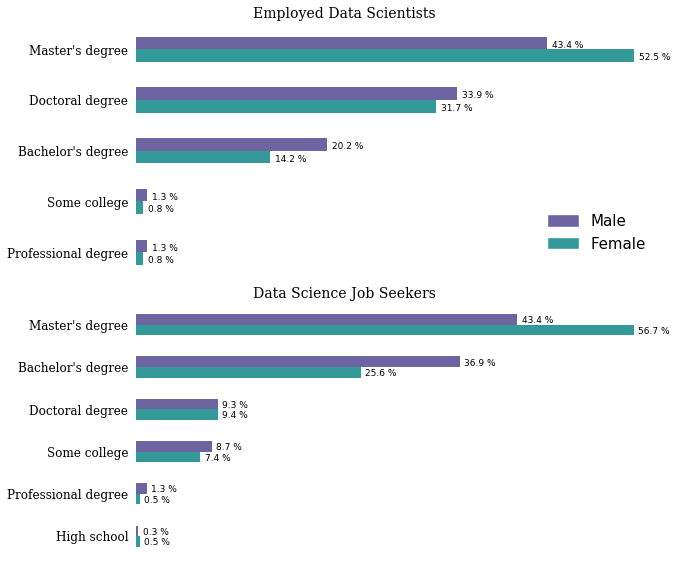

In [14]:
df1a=df_working.loc[df_working['CurrentJobStatus']=='Employed FullTime']
df2a=df1a.groupby(['GenderSelect','FormalEducation']).agg({'index': 'count'})
df3a= df2a.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
df3a['FormalEducation']=df3a['FormalEducation'].replace("Some college/university study \
without earning a bachelor's degree",'Some college')
df4a=pd.pivot_table(df3a, index=['GenderSelect'], values=['index'], \
                   columns='FormalEducation',aggfunc='mean').T.\
reset_index().iloc[:,1:].sort_values(by='Male',ascending=True)


df1b=df_working.loc[df_working['CurrentJobStatus']!='Employed FullTime']
df2b=df1b.groupby(['GenderSelect','FormalEducation']).agg({'index': 'count'})
df3b= df2b.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
df3b['FormalEducation']=df3b['FormalEducation'].replace("Some college/university study \
without earning a bachelor's degree",'Some college')
df3b['FormalEducation']=df3b['FormalEducation'].replace("I did not complete any formal education past high school",'High school')
df4b=pd.pivot_table(df3b, index=['GenderSelect'], values=['index'], \
                   columns='FormalEducation',aggfunc='mean').T.\
reset_index().iloc[:,1:].sort_values(by='Male',ascending=True)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
plt.tight_layout(h_pad=.5)

df4a[[ 'Female','Male']].plot(kind='barh',
               color=['teal','darkslateblue'],ax=ax[0],fontsize=13, alpha=.8)
ax[0].set_title('Employed Data Scientists',\
                  x=.4, fontsize=14,family='serif')
for i in ax[0].patches:
        ax[0].text(i.get_width()+.5, i.get_y()+.04, \
            '{:.1f} %'.format(i.get_width()), fontsize=9)
leg=ax[0].legend(['Male','Female'], loc='lower right', \
          fontsize=10,prop={'size':15},bbox_to_anchor=(1, .05)) 
leg.legendHandles[0].set_color('darkslateblue')
leg.legendHandles[1].set_color('teal')
ax[0].set_facecolor('white')
ax[0].yaxis.set_ticks_position('none')
ax[0].xaxis.set_ticks_position('none')
ax[0].get_xaxis().set_ticks([])
ax[0].set_yticklabels(df4a['FormalEducation'],
                      size =12,family='serif', color='black')

leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

df4b[[ 'Female','Male']].plot(kind='barh',
               color=['teal','darkslateblue'],ax=ax[1],fontsize=13, alpha=.8)

for i in ax[1].patches:
        ax[1].text(i.get_width()+.5, i.get_y()+.04, \
            '{:.1f} %'.format(i.get_width()), fontsize=9)
ax[1].set_title('Data Science Job Seekers',\
                  x=.4, fontsize=14,family='serif')
leg=ax[1].legend().set_visible(False)
ax[1].set_facecolor('white')
ax[1].yaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[1].get_xaxis().set_ticks([])
ax[1].set_yticklabels(df4b['FormalEducation'],\
                      size =12,family='serif', color='black')
plt.show()

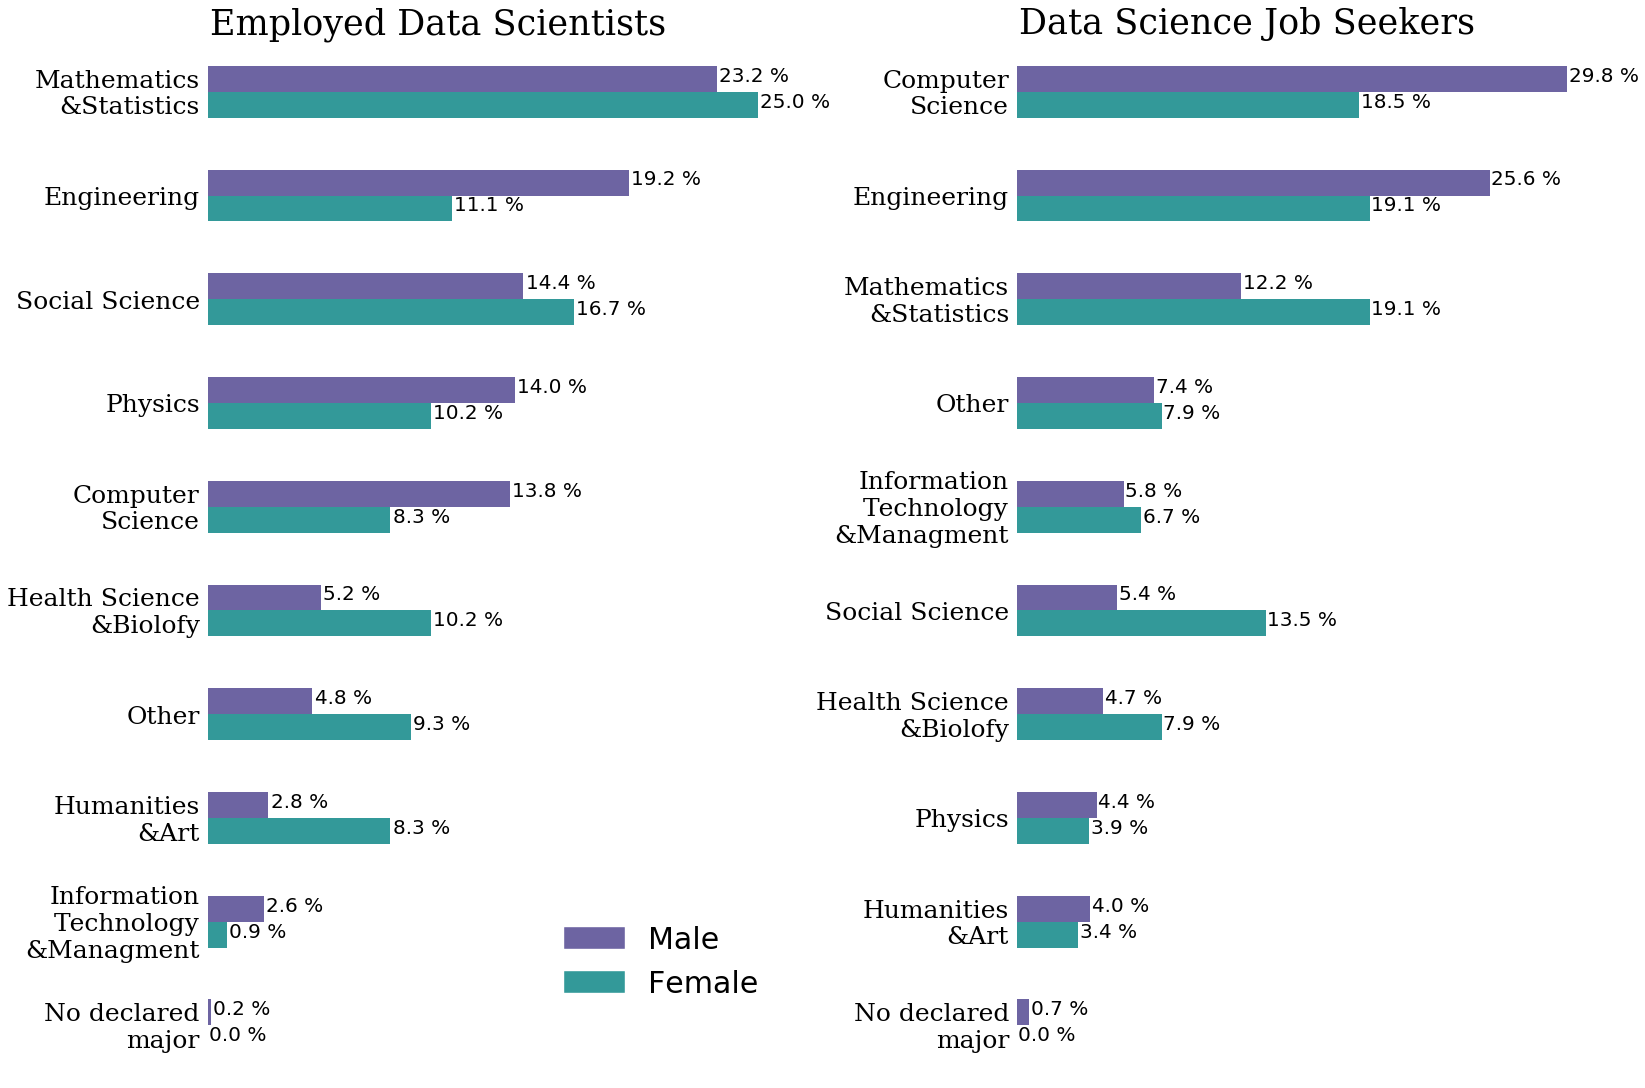

In [15]:
df1a=df_working.loc[df_working['CurrentJobStatus']=='Employed FullTime']
df2a=df1a.groupby(['GenderSelect','Major']).agg({'index': 'count'})
df3a= df2a.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
df4a=pd.pivot_table(df3a, index=['GenderSelect'], values=['index'], \
                   columns='Major',aggfunc='mean').T.\
reset_index().iloc[:,1:].sort_values(by='Male',ascending=True)


df1b=df_working.loc[df_working['CurrentJobStatus']!='Employed FullTime']
df2b=df1b.groupby(['GenderSelect','Major']).agg({'index': 'count'})
df3b= df2b.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
df4b=pd.pivot_table(df3b, index=['GenderSelect'], values=['index'], \
                   columns='Major',aggfunc='mean').T.\
reset_index().iloc[:,1:].sort_values(by='Male',ascending=True)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,15))
plt.tight_layout(w_pad=20)

df4a[[ 'Female','Male']].plot(kind='barh',
               color=['teal','darkslateblue'],ax=ax[0],fontsize=13, alpha=.8)
ax[0].set_title('Employed Data Scientists',\
                  y=1.01,x=.4, fontsize=35,family='serif')
for i in ax[0].patches:
        ax[0].text(i.get_width()+.1, i.get_y()+.10, \
            '{:.1f} %'.format(i.get_width()), fontsize=20)
leg=ax[0].legend(['Male','Female'], loc='lower right', \
          fontsize=20,prop={'size':30},bbox_to_anchor=(1, .05)) 
leg.legendHandles[0].set_color('darkslateblue')
leg.legendHandles[1].set_color('teal')
ax[0].set_facecolor('white')
ax[0].yaxis.set_ticks_position('none')
ax[0].xaxis.set_ticks_position('none')
ax[0].get_xaxis().set_ticks([])
ax[0].set_yticklabels(['Mathematics\n&Statistics','Engineering',\
                      'Social Science','Physics', \
                       'Computer\nScience','Health Science\n&Biolofy',
                      'Other','Humanities\n&Art',\
                      'Information\nTechnology\n&Managment',\
                       'No declared\nmajor'][::-1],
                      size =25,family='serif', color='black')

leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

df4b[[ 'Female','Male']].plot(kind='barh',
               color=['teal','darkslateblue'],ax=ax[1],fontsize=13, alpha=.8)

for i in ax[1].patches:
        ax[1].text(i.get_width()+.1, i.get_y()+.10, \
            '{:.1f} %'.format(i.get_width()), fontsize=20)
ax[1].set_title('Data Science Job Seekers',\
                  y=1.01,x=.4, fontsize=35,family='serif')
leg=ax[1].legend().set_visible(False)
ax[1].set_facecolor('white')
ax[1].yaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[1].get_xaxis().set_ticks([])
ax[1].set_yticklabels(['Computer\nScience', 'Engineering',\
                       'Mathematics\n&Statistics','Other',\
                       'Information\nTechnology\n&Managment',\
                       'Social Science','Health Science\n&Biolofy',\
                       'Physics','Humanities\n&Art','No declared\nmajor'][::-1],\
                      size =25,family='serif', color='black')
plt.show()


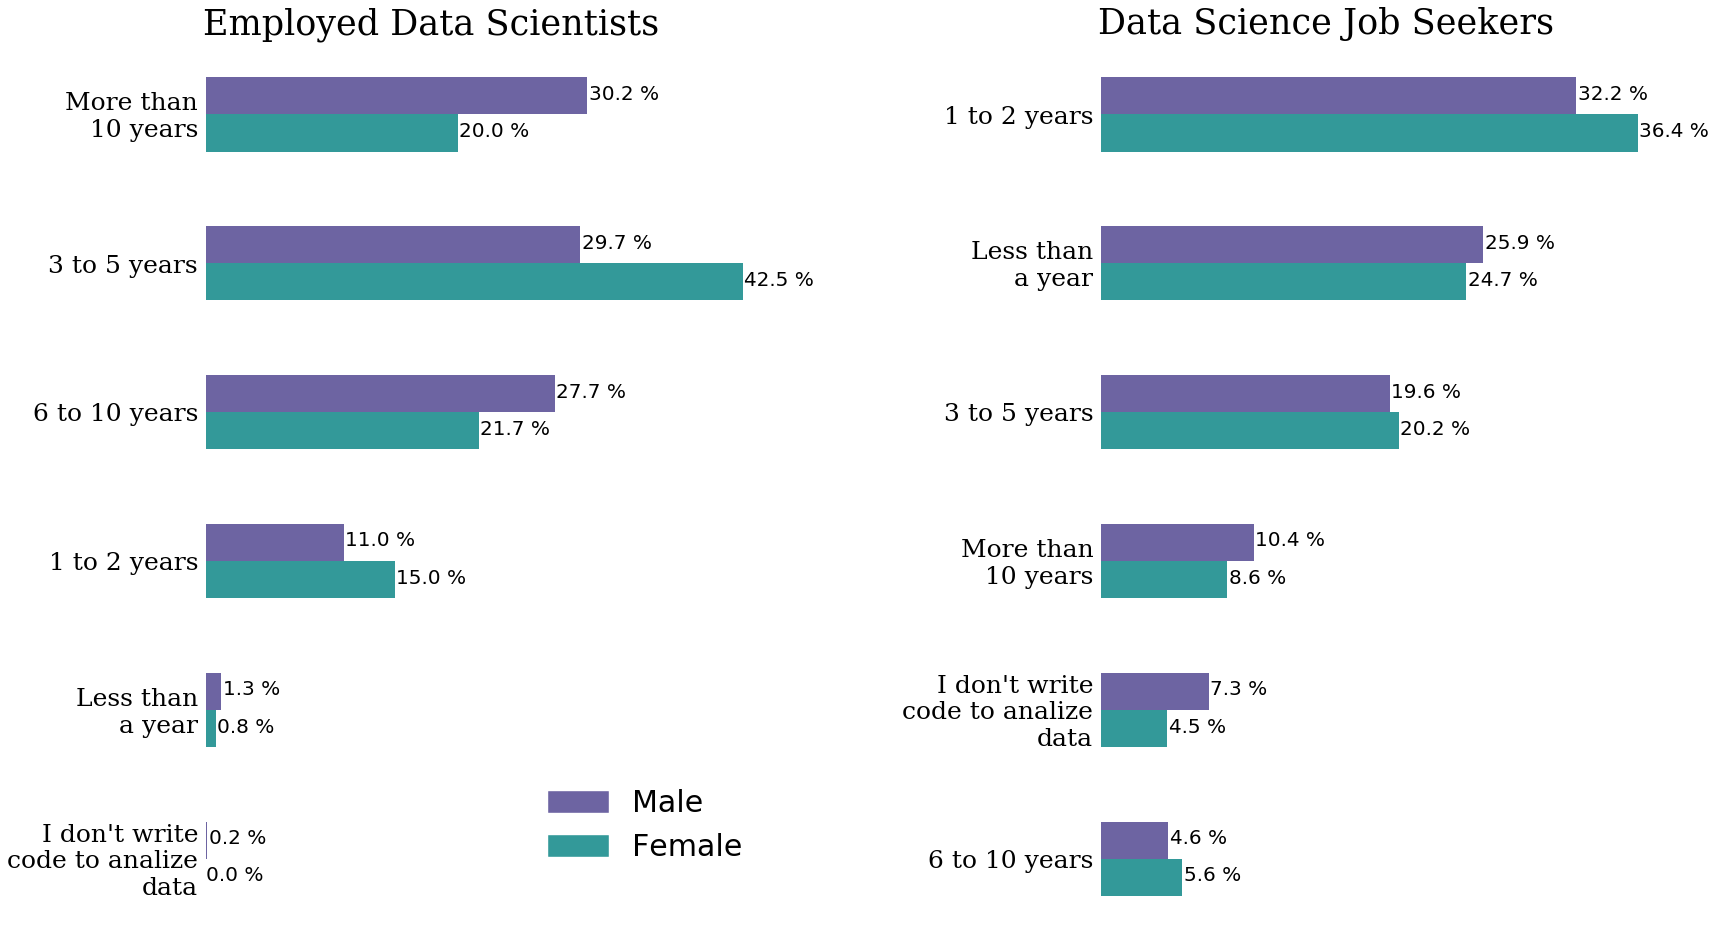

In [16]:
df1a=df_working.loc[df_working['CurrentJobStatus']=='Employed FullTime']
df2a=df1a.groupby(['GenderSelect','Tenure']).agg({'index': 'count'})
df3a= df2a.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
df4a=pd.pivot_table(df3a, index=['GenderSelect'], values=['index'], \
                   columns='Tenure',aggfunc='mean').T.\
reset_index().iloc[:,1:].sort_values(by='Male',ascending=True)


df1b=df_working.loc[df_working['CurrentJobStatus']!='Employed FullTime']
df2b=df1b.groupby(['GenderSelect','Tenure']).agg({'index': 'count'})
df3b= df2b.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
df4b=pd.pivot_table(df3b, index=['GenderSelect'], values=['index'], \
                   columns='Tenure',aggfunc='mean').T.\
reset_index().iloc[:,1:].sort_values(by='Male',ascending=True)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21,13))
plt.tight_layout(w_pad=30)


df4a[[ 'Female','Male']].plot(kind='barh',
               color=['teal','darkslateblue'],ax=ax[0],fontsize=13, alpha=.8)
ax[0].set_title('Employed Data Scientists',\
                  y=1.01,x=.4, fontsize=35,family='serif')
for i in ax[0].patches:
        ax[0].text(i.get_width()+.1, i.get_y()+.10, \
            '{:.1f} %'.format(i.get_width()), fontsize=20)
leg=ax[0].legend(['Male','Female'], loc='lower right', \
          fontsize=20,prop={'size':30},bbox_to_anchor=(1, .05)) 
leg.legendHandles[0].set_color('darkslateblue')
leg.legendHandles[1].set_color('teal')
ax[0].set_facecolor('white')
ax[0].yaxis.set_ticks_position('none')
ax[0].xaxis.set_ticks_position('none')
ax[0].get_xaxis().set_ticks([])
ax[0].set_yticklabels(['More than\n10 years','3 to 5 years',\
                      '6 to 10 years','1 to 2 years','Less than\na year',
                      "I don't write\ncode to analize\ndata"][::-1],
                      size =25,family='serif', color='black')

leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

df4b[[ 'Female','Male']].plot(kind='barh',
               color=['teal','darkslateblue'],ax=ax[1],fontsize=13, alpha=.8)

for i in ax[1].patches:
        ax[1].text(i.get_width()+.1, i.get_y()+.10, \
            '{:.1f} %'.format(i.get_width()), fontsize=20)
ax[1].set_title('Data Science Job Seekers',\
                  y=1.01,x=.4, fontsize=35,family='serif')
leg=ax[1].legend().set_visible(False)
ax[1].set_facecolor('white')
ax[1].yaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[1].get_xaxis().set_ticks([])
ax[1].set_yticklabels(['1 to 2 years','Less than\na year','3 to 5 years','More than\n10 years',\
                      "I don't write\ncode to analize\ndata", '6 to 10 years'][::-1],
                      size =25,family='serif', color='black')
plt.show()


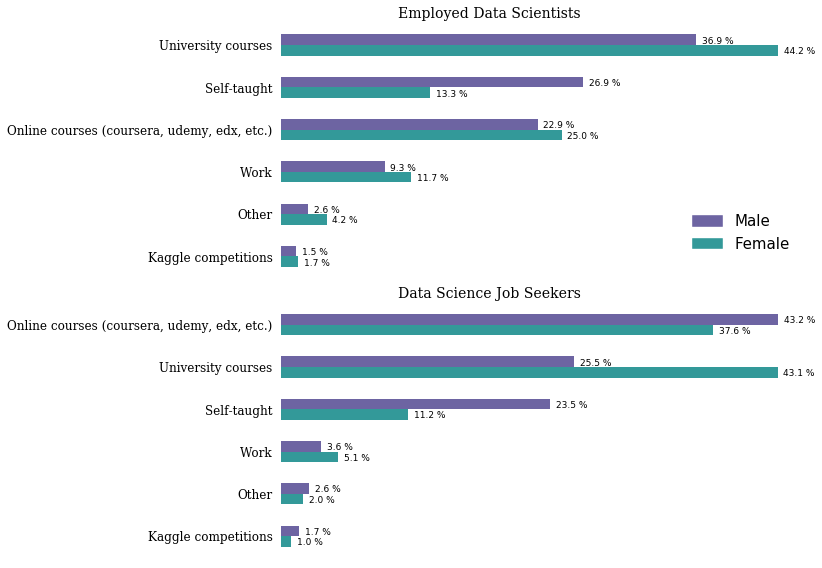

In [17]:
df1a=df_working.loc[df_working['CurrentJobStatus']=='Employed FullTime']
df2a=df1a.groupby(['GenderSelect','FirstTrainingSelect']).agg({'index': 'count'})
df3a= df2a.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
df4a=pd.pivot_table(df3a, index=['GenderSelect'], values=['index'], \
                   columns='FirstTrainingSelect',aggfunc='mean').T.\
reset_index().iloc[:,1:].sort_values(by='Male',ascending=True)


df1b=df_working.loc[df_working['CurrentJobStatus']!='Employed FullTime']
df2b=df1b.groupby(['GenderSelect','FirstTrainingSelect']).agg({'index': 'count'})
df3b= df2b.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()

df4b=pd.pivot_table(df3b, index=['GenderSelect'], values=['index'], \
                   columns='FirstTrainingSelect',aggfunc='mean').T.\
reset_index().iloc[:,1:].sort_values(by='Male',ascending=True)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
plt.tight_layout(h_pad=.5)

df4a[[ 'Female','Male']].plot(kind='barh',
               color=['teal','darkslateblue'],ax=ax[0],fontsize=13, alpha=.8)
ax[0].set_title('Employed Data Scientists',\
                  x=.4, fontsize=14,family='serif')
for i in ax[0].patches:
        ax[0].text(i.get_width()+.5, i.get_y()+.04, \
            '{:.1f} %'.format(i.get_width()), fontsize=9)
leg=ax[0].legend(['Male','Female'], loc='lower right', \
          fontsize=10,prop={'size':15},bbox_to_anchor=(1, .05)) 
leg.legendHandles[0].set_color('darkslateblue')
leg.legendHandles[1].set_color('teal')
ax[0].set_facecolor('white')
ax[0].yaxis.set_ticks_position('none')
ax[0].xaxis.set_ticks_position('none')
ax[0].get_xaxis().set_ticks([])
ax[0].set_yticklabels(df4a['FirstTrainingSelect'],
                      size =12,family='serif', color='black')

leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

df4b[[ 'Female','Male']].plot(kind='barh',
               color=['teal','darkslateblue'],ax=ax[1],fontsize=13, alpha=.8)

for i in ax[1].patches:
        ax[1].text(i.get_width()+.5, i.get_y()+.04, \
            '{:.1f} %'.format(i.get_width()), fontsize=9)
ax[1].set_title('Data Science Job Seekers',\
                  x=.4, fontsize=14,family='serif')
leg=ax[1].legend().set_visible(False)
ax[1].set_facecolor('white')
ax[1].yaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[1].get_xaxis().set_ticks([])
ax[1].set_yticklabels(df4b['FirstTrainingSelect'],\
                      size =12,family='serif', color='black')
plt.show()

In [18]:
df1 = pd.DataFrame(columns=['Gender','Status','Percentage'])
JobStatus=list(df_working.CurrentJobStatus.unique())
for status in JobStatus:
    y=df_working[df_working['CurrentJobStatus']==status]
    data=pd.DataFrame(y['GenderSelect'].value_counts(normalize=True)).reset_index()
    data['CurrentJobStatus']=status
    for index, row in data.iterrows():
        df1=df1.append({'Gender':row['index'], \
                              'Status':row['CurrentJobStatus'],\
                              'Percentage':row['GenderSelect']},\
                             ignore_index=True)
    
        df2=pd.pivot_table(df1, index=['Gender'], values=['Percentage'], \
                   columns='Status',aggfunc='sum').T.reset_index().iloc[:,1:].\
        sort_values(by='Male',ascending=True)

In [19]:
df1a=df_working.loc[df_working['CurrentJobStatus']=='Employed FullTime']
df2a=pd.pivot_table(df1a, index=['GenderSelect'], values=['LearningCategoryWork',\
                        'LearningCategorySelftTaught','LearningCategoryOnlineCourses',
                         'LearningCategoryUniversity','LearningCategoryKaggle','LearningCategoryOther']).\
sort_values(by='Female', axis=1).reset_index(drop=True)

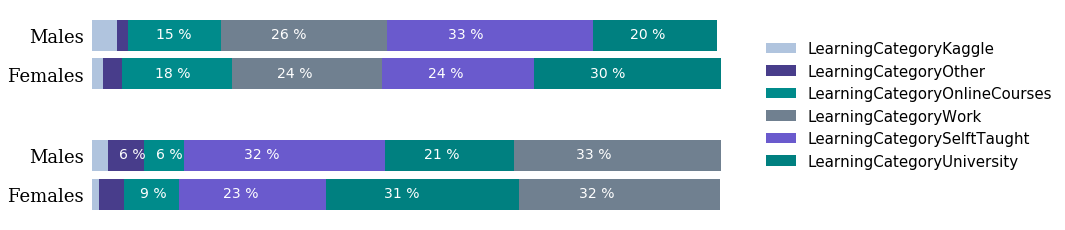

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,3.5))
plt.tight_layout(h_pad=1)

plt.style.use('ggplot')

df1a=df_working.loc[df_working['CurrentJobStatus']=='Employed FullTime']
df2a=pd.pivot_table(df1a, index=['GenderSelect'], values=['LearningCategoryWork',\
                        'LearningCategorySelftTaught','LearningCategoryOnlineCourses',
                         'LearningCategoryUniversity','LearningCategoryKaggle','LearningCategoryOther']).\
sort_values(by='Female', axis=1).reset_index()

df1b=df_working.loc[df_working['CurrentJobStatus']!='Employed FullTime']
df2b=pd.pivot_table(df1b, index=['GenderSelect'], values=['LearningCategoryWork',\
                        'LearningCategorySelftTaught','LearningCategoryOnlineCourses',
                         'LearningCategoryUniversity','LearningCategoryKaggle','LearningCategoryOther']).\
sort_values(by='Female', axis=1).reset_index()


df2a.plot.barh(stacked=True, color=['lightsteelblue', 'darkslateblue','darkcyan','slategrey','slateblue','teal'], ax=ax[0],width=.8)
for p in ax[0].patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if p.get_width()<5:
        pass
    else:
        ax[0].annotate('{:.0f} %'.format(width), (p.get_x()+.3*width, p.get_y()+.4*height),size=14,color='white')
ax[0].set_facecolor('white')
ax[0].get_xaxis().set_ticks([])
ax[0].xaxis.set_ticks_position('none')
ax[0].yaxis.set_ticks_position('none')
ax[0].set_yticklabels(['Females', 'Males'], size =18,family='serif', color='black')
leg=ax[0].legend(loc='best', \
          fontsize=8,bbox_to_anchor=(1, .8),prop={'size':15}) 
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')
ax[0].yaxis.grid(False)


df2b.plot.barh(stacked=True, color=['lightsteelblue', 'darkslateblue','darkcyan','slateblue','teal','slategrey'], ax=ax[1],width=.8)
for p in ax[1].patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if p.get_width()<5:
        pass
    else:
        ax[1].annotate('{:.0f} %'.format(width), (p.get_x()+.3*width, p.get_y()+.4*height),size=14, color='white')
ax[1].set_facecolor('white')
ax[1].get_xaxis().set_ticks([])
ax[1].xaxis.set_ticks_position('none')
ax[1].yaxis.set_ticks_position('none')
ax[1].set_yticklabels(['Females', 'Males'], size =18,family='serif', color='black')
leg=ax[1].legend().set_visible(False)
ax[1].yaxis.grid(False)
plt.show()

In [21]:
df_working.to_csv('working.csv')

In [24]:
df_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 15 columns):
index                            1498 non-null int64
GenderSelect                     1496 non-null object
Age_cat                          1498 non-null object
FormalEducation                  1473 non-null object
Major                            1340 non-null object
Tenure                           1453 non-null object
FirstTrainingSelect              1454 non-null object
EmploymentStatus                 1498 non-null object
LearningCategoryWork             1420 non-null float64
LearningCategorySelftTaught      1418 non-null float64
LearningCategoryOnlineCourses    1419 non-null float64
LearningCategoryUniversity       1420 non-null float64
LearningCategoryKaggle           1420 non-null float64
LearningCategoryOther            1419 non-null float64
CurrentJobStatus                 1498 non-null object
dtypes: float64(6), int64(1), object(8)
memory usage: 175.6+ KB
